I have a corpus (body of text), and i want to estimate the words representations in the corpus

In [700]:
import numpy as np
import matplotlib.pyplot as plt

In [709]:
text = '''
When forty winters shall besiege thy brow,
And dig deep trenches in thy beauty's field,
Thy youth's proud livery so gazed on now,
Will be a tattered weed of small worth held:  
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise.
How much more praise deserved thy beauty's use,
If thou couldst answer 'This fair child of mine
Shall sum my count, and make my old excuse'
Proving his beauty by succession thine.
This were to be new made when thou art old,
And see thy blood warm when thou feel'st it cold.
When forty winters shall besiege thy brow,
And dig deep trenches in thy beauty's field,
Thy youth's proud livery so gazed on now,
Will be a tattered weed of small worth held:  
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise.
How much more praise deserved thy beauty's use,
If thou couldst answer 'This fair child of mine
Shall sum my count, and make my old excuse'
Proving his beauty by succession thine.
This were to be new made when thou art old,
And see thy blood warm when thou feel'st it cold.
When forty winters shall besiege thy brow,
And dig deep trenches in thy beauty's field,
Thy youth's proud livery so gazed on now,
Will be a tattered weed of small worth held:  
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise.
How much more praise deserved thy beauty's use,
If thou couldst answer 'This fair child of mine
Shall sum my count, and make my old excuse'
Proving his beauty by succession thine.
This were to be new made when thou art old,
And see thy blood warm when thou feel'st it cold.
'''

In [710]:
text

"\nWhen forty winters shall besiege thy brow,\nAnd dig deep trenches in thy beauty's field,\nThy youth's proud livery so gazed on now,\nWill be a tattered weed of small worth held:  \nThen being asked, where all thy beauty lies,\nWhere all the treasure of thy lusty days;\nTo say within thine own deep sunken eyes,\nWere an all-eating shame, and thriftless praise.\nHow much more praise deserved thy beauty's use,\nIf thou couldst answer 'This fair child of mine\nShall sum my count, and make my old excuse'\nProving his beauty by succession thine.\nThis were to be new made when thou art old,\nAnd see thy blood warm when thou feel'st it cold.\nWhen forty winters shall besiege thy brow,\nAnd dig deep trenches in thy beauty's field,\nThy youth's proud livery so gazed on now,\nWill be a tattered weed of small worth held:  \nThen being asked, where all thy beauty lies,\nWhere all the treasure of thy lusty days;\nTo say within thine own deep sunken eyes,\nWere an all-eating shame, and thriftless 

In [711]:
def tokenize(text):
    return text.lower().split()

In [712]:
tokens = tokenize(text)
vocab_size = len(set(tokens))
corpus_size = len(tokens)
tokens[:3], vocab_size

(['when', 'forty', 'winters'], 90)

```
Approch #1:
for each word there is an initial representations for it:
for example: word -> [0, 0, 0, 0, 1, 0, 0, 0, ...]
which is a one-hot vector that represents the word in the corpus, where the size of the vector is the 'vocab_size'
```

In [713]:
token_to_id = {t:i for i, t in enumerate(set(tokens))}
id_to_token = {i:t for i, t in enumerate(set(tokens))}

In [714]:
def encode(token, idx):
    vector = [0] * vocab_size
    vector[idx] = 1
    return vector

```
generate training data from the corpus, based on window
for each token the corpus we're going to take the context (outside words) of the token and consider it as the label, and the token going to be the input:
for example:
            <context>  <token>   <context>
    text: 'when forty [winters] shall besiege'
    window size = 2 -- two from both the left and the 
                       right of the token.
                       
centers:    contexts:
   winters -> when 
   winters -> forty
   winters -> shall
   winters -> besiege
   
   but they aren't represented as a text words,
   instead going to be:
   x:                      y:
   [..., 0, 1, 0, ...] -> [..., 1, 0, 0, ...]
   [..., 1, 0, 0, ...] -> [..., 0, 1, 0, ...]
    .
    ..
    ...
```

In [715]:
def combine(*iterables):
    for iterable in iterables:
        yield from iterable

In [716]:
def generate(tokens, vocab_size, token_to_id, window_size):
    """
    Generate training data from the corpus,
    based on window for each token the corpus we're
    going to take the context (outside words) of the token
    and consider it as the label,
    and the token going to be the input:
    
    for example:
                       <CONTEXT>   <CENTER>   <CONTEXT>
        INPUT TEXT  = 'when forty [winters] shall besiege'
        WINDOW SIZE = 2 -- two from both the left and the 
                           right of the token.
                           
       centers ->  contexts
       ---------------------
       winters -> when 
       winters -> forty
       winters -> shall
       winters -> besiege

       but they aren't represented as a text words,
       instead going to be:
       
       centers ->  contexts
       ------------------------------------------
       [..., 0, 1, 0, ...] -> [..., 1, 0, 0, ...]
       [..., 1, 0, 0, ...] -> [..., 0, 1, 0, ...]
    """
    centers = []
    contexts = []
    for idx, center in enumerate(tokens):
        # window (local context) form the left-side, and right-side
        left = range(max(0, (idx - window_size)), idx)
        right = range(idx + 1, min(len(tokens), idx + window_size + 1)) 
        local_context = combine(left, right)
        for c in local_context:
            context = tokens[c]
            centers.append(encode(center, token_to_id[center]))
            contexts.append(encode(context, token_to_id[context]))
            
    return np.array(centers), np.array(contexts)

In [717]:
centers, contexts = generate(tokens, vocab_size, token_to_id, 2)
centers.shape, contexts.shape

((1374, 90), (1374, 90))

In [718]:
np.random.seed(42)

In [719]:
def initialize(vocab_size, embedding_size):
    model = {
        "W1": np.random.randn(vocab_size, embedding_size),
        "W2": np.random.randn(embedding_size, vocab_size)
    }
    return model

In [720]:
model = initialize(vocab_size, 10)

In [721]:
def softmax(X):
    exp = np.exp(X)
    return exp / np.sum(exp)

In [722]:
def forward(model, X):
    cache = {}
    cache['A1'] = X @ model['W1']
    cache['A2'] = cache['A1'] @ model['W2']
    cache['Z'] = softmax(cache['A2'])
    return cache

In [723]:
cache = forward(model, centers)

In [724]:
id_to_token[np.argmax(contexts[0])]

'forty'

In [725]:
id_to_token[np.argmax(cache['Z'][0])]

'now,'

In [726]:
def cross_entropy_loss(actual, prediction):
    loss = - np.sum(actual * np.log(prediction))
    return loss

In [727]:
cross_entropy_loss(centers, cache['Z'])

25774.040293245638

```
BACKPROB

A1 =    X         @     W1
    (obs, voca)      (voca, embds)
A2 =    A1        @     W2
    (obs, embds)      (embds, voca)
    
Z = Softmax(A2)
(obs, voca)


Z = Softmax((X @ W1) @ W2)
LOSS = CCE(Z)

update w2 (embds, voca):
dl/dw2 = dl/dz * dz/a2 * a2/w2
dl/dw2 =    a1.T * z - y ------> (Eq1)
         (embds, obs) (obs, voca)


update w1 (voca, embds):

dl/dw1 = dl/dz * dz/da2 * da2/da1        * da1/dw1
       = [z - y       ] * W2             * X
       = (obs, voca)    * (embds, voca)  * (obs, voca)
       
       = X.T @ [z - y] @ W2.T ------> (Eq2)
          (voca, embds)

```

In [728]:
def backword(model, X, y, alpha):
    cache = forward(model, X)
    dW2 = cache['A1'].T @ (cache['Z'] - y)
    dW1 = (X.T @ ((cache['Z'] - y) @ model['W2'].T))
    
    model['W2'] = model['W2'] - (alpha * dW2)
    model['W1'] = model['W1'] - (alpha * dW1)
    
    return cross_entropy_loss(X, cache['Z'])

In [729]:
iterations = 50
history = [backword(model, centers, contexts, 0.001) for _ in range(iterations)]

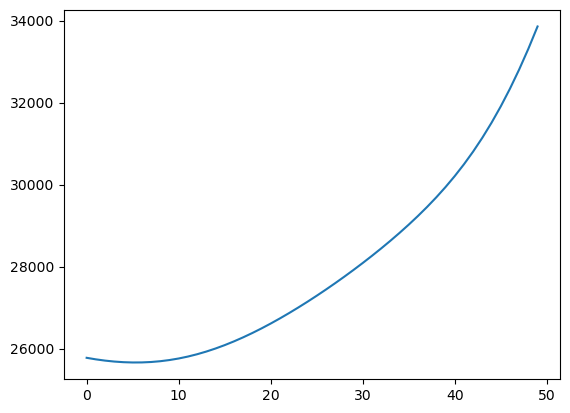

In [730]:
fig, ax = plt.subplots()
ax.plot(range(len(history)), history)
plt.show()